In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.saving import load_model
from tensorflow.keras.optimizers import SGD, RMSprop
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
from skimage import data
!nvidia-smi
tf.device('/device:GPU:0')
print(tf.config.list_physical_devices())

2024-05-26 17:39:30.021297: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 17:39:31.239480: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/bin/bash: /home/mayoi/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun May 26 17:39:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.76.01              Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   56C    P0             26W /  118W |       0MiB /   8192MiB |      0%      Default |
|                      

2024-05-26 17:39:35.386099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-26 17:39:35.820863: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-26 17:39:35.821083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-26 17:39:35.825499: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-26 17:39:35.825856: I tensorflow/compile

In [3]:
import os
from tqdm import tqdm
import shutil 
train_dir = "./train2"
# real_train_dir = os.path.join(train_dir, "REAL")
# fake_train_dir = os.path.join(train_dir, "FAKE")

In [6]:
newPath = "./test3"

In [8]:
for i in os.listdir(train_dir):
    print(i)
    real_train_dir = os.path.join(train_dir, i)

    # Create the new directories if they don't exist
    if not os.path.exists(os.path.join(newPath, i)):
        os.makedirs(os.path.join(newPath, i))
    if True  :
        for j in tqdm(os.listdir(train_dir + '/' + i)[50000:75000]):
            shutil.copy(os.path.join(train_dir, i,j), os.path.join(newPath, i,j))
            # image_co_occurrence_matrix = co_occurrence_matrix_color(os.path.join(train_dir, i,j),direction=(25, 25))

            # cv2.imwrite(os.path.join(newPath, i,j), image_co_occurrence_matrix)

REAL


100%|██████████| 25000/25000 [00:37<00:00, 671.87it/s]


FAKE


100%|██████████| 25000/25000 [00:40<00:00, 610.01it/s]


In [10]:
import os
import numpy as np
import pandas as pd
from skimage import io, color
from skimage.feature import graycomatrix, graycoprops

def co_occurrence_matrix(image_path, direction=(0, 1), levels=256):
    # Load the image
    image = io.imread(image_path)
    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:
        image = color.rgb2gray(image)
    # Quantize the image to the specified levels
    image = (image * (levels - 1)).astype(np.uint8)
    # Calculate the GLCM
    glcm = graycomatrix(image, distances=[1], angles=[np.pi * direction[0] / 4], levels=levels, symmetric=True, normed=True)
    return glcm

def calculate_texture_features(glcm):
    # Compute several features from the GLCM
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    ASM = graycoprops(glcm, 'ASM')[0, 0]
    # Entropy calculation
    entropy = -np.sum(glcm * np.log2(glcm + 1e-10))  # add a small value to avoid log(0)
    return {
        'Contrast': contrast,
        'Correlation': correlation,
        'Energy': energy,
        'Homogeneity': homogeneity,
        'ASM': ASM,
        'Entropy': entropy
    }



# Example usage


       Contrast  Correlation    Energy  Homogeneity       ASM    Entropy Class
0    212.383074     0.983284  0.064031     0.588613  0.004100  10.806095  REAL
1    206.437694     0.983397  0.080436     0.530931  0.006470  10.866290  REAL
2    138.982751     0.985723  0.457575     0.778929  0.209375   6.277492  REAL
3    130.799911     0.970127  0.072710     0.654944  0.005287   9.763761  REAL
4    227.654439     0.976460  0.180253     0.544367  0.032491  10.214341  REAL
5    375.867918     0.960822  0.053465     0.489466  0.002858  11.503777  REAL
6    291.031033     0.924876  0.099899     0.680873  0.009980   9.259880  REAL
7     67.332254     0.947573  0.130477     0.697207  0.017024   8.312523  REAL
8    199.589733     0.973905  0.249952     0.599257  0.062476   9.405148  REAL
9    275.726822     0.977117  0.379031     0.741084  0.143664   7.302537  REAL
10   150.073491     0.985939  0.060413     0.552437  0.003650  10.840203  REAL
11   165.412476     0.986991  0.577983     0.808475 

In [7]:
from skimage import io, color

def co_occurrence_matrix(image_path, distances=[1, 5, 20], levels=256):
    # Load the image
    # image = io.imread(image_path)
    
    image = image_path
    # Check if the image has an alpha channel; if so, drop it
    if image.shape[-1] == 4:
        image = image[..., :3]  # Keep only the first three channels (RGB)

    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:
        image = color.rgb2gray(image)
    else :
        image_gray = image        
        
    # Quantize the image to the specified levels
    image = (image * (levels - 1)).astype(np.uint8)
    
    # Define angles for 0, 45, 90, 135 degrees in radians
    angles = [0, np.pi/4, np.pi/2] 
    # Calculate the GLCM
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    return glcm

def calculate_color_histogram(image, bins=256, channel_mask=[True, True, True]):
    # Calculate histograms for each channel
    histograms = []
    for i in range(3):  # Assuming the image has three channels (RGB)
        if channel_mask[i]:
            hist, _ = np.histogram(image[:, :, i], bins=bins, range=(0, 256), density=True)
            histograms.append(hist)
        else:
            histograms.append(np.zeros(bins))  # Append zeros if channel is masked
    return np.concatenate(histograms)

def calculate_texture_features(glcm):
    # Initialize a dictionary to store aggregated features
    features = {

    }
    # Number of directions
    num_directions = glcm.shape[2]
    num_anles = glcm.shape[3]
    
    # Compute features for each direction and average them
    for j in range(num_directions):
        for k in range(num_anles):
            features[f'Contrast_{j}_{k}'] = graycoprops(glcm, 'contrast',)[j, k]
            features[f'Correlation_{j}_{k}'] = graycoprops(glcm, 'correlation')[j, k]
            features[f'Energy_{j}_{k}'] = graycoprops(glcm, 'energy')[j, k]
            features[f'Homogeneity_{j}_{k}'] = graycoprops(glcm, 'homogeneity')[j, k]
            features[f'ASM_{j}_{k}'] = graycoprops(glcm, 'ASM')[j, k]
            features[f'Dissimilarity_{j}_{k}'] = graycoprops(glcm, 'dissimilarity')[j, k]
            entropy = -np.sum(glcm[:, :, j, k] * np.log2(glcm[:, :, j, k] + 1e-10))
            features[f'Entropy_{j}_{k}'] = entropy

    # Average the features over the number of directions
    for key in features:
        features[key] /= num_directions

    return features

In [6]:
def lbglcm_calculator(image_url ,radius = 3  ):
    # image = io.imread(image_url)
    image = image_url
    # Check if the image has an alpha channel; if so, drop it
    if image.shape[-1] == 4:
        image = image[..., :3]  # Keep only the first three channels (RGB
    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:
        image_gray = color.rgb2gray(image)
    else :
        image_gray = image
    
    # image_gray = img_as_ubyte(rgb2gray(image))

    n_points = 8 * radius 

    lbp_image = local_binary_pattern(image_gray, n_points, radius, method="uniform")

    lbglcm = graycomatrix(lbp_image.astype(np.uint8), distances=[1, 5, 20], angles = [0, np.pi/4, np.pi/2] , levels=256)
    return lbglcm

def calculate_texture_features_lbglcm(lbglcm):
    # Initialize a dictionary to store aggregated features
    features = {

    }
    # Number of directions
    num_directions = lbglcm.shape[2]
    num_anles = lbglcm.shape[3]
    
    # Compute features for each direction and average them
    for j in range(num_directions):
        for k in range(num_anles):
            features[f'lbglcm_Contrast_{j}_{k}'] = graycoprops(lbglcm, 'contrast',)[j, k]
            features[f'lbglcm_Correlation_{j}_{k}'] = graycoprops(lbglcm, 'correlation')[j, k]
            features[f'lbglcm_Energy_{j}_{k}'] = graycoprops(lbglcm, 'energy')[j, k]
            features[f'lbglcm_Homogeneity_{j}_{k}'] = graycoprops(lbglcm, 'homogeneity')[j, k]
            features[f'lbglcm_ASM_{j}_{k}'] = graycoprops(lbglcm, 'ASM')[j, k]
            features[f'lbglcm_Dissimilarity_{j}_{k}'] = graycoprops(lbglcm, 'dissimilarity')[j, k]
            entropy = -np.sum(lbglcm[:, :, j, k] * np.log2(lbglcm[:, :, j, k] + 1e-10))
            features[f'lbglcm_Entropy_{j}_{k}'] = entropy

    # Average the features over the number of directions
    for key in features:
        features[key] /= num_directions

    return features


In [9]:
import numpy as np
from skimage import color, io, img_as_ubyte

def calculate_glrlm(image, levels=256):
    # Check if image is RGBA, if so, convert to RGB
    if image.shape[-1] == 4:
        image = image[..., :3]  # Discard alpha channel

    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:
        image = color.rgb2gray(image)
    else :
        image_gray = image
    # Ensure the image is in the correct format
    image = img_as_ubyte(image)

    # Initialize the GLRLM matrix
    max_run_length = image.shape[1]  # maximum run length possible is the number of columns
    glrlm = np.zeros((levels, max_run_length), dtype=int)
    
    # Calculate GLRLM
    for i in range(image.shape[0]):  # for each row
        run_length = 0
        previous_value = image[i, 0]
        for j in range(image.shape[1]):  # for each column
            if image[i, j] == previous_value:
                run_length += 1
            else:
                if run_length > 0:
                    glrlm[previous_value, run_length - 1] += 1
                run_length = 1
                previous_value = image[i, j]
        if run_length > 0:
            glrlm[previous_value, run_length - 1] += 1  # For the last run in the row

    return glrlm

def short_runs_emphasis(glrlm):
    # Calculate Short Runs Emphasis
    j = np.arange(1, glrlm.shape[1] + 1)
    denominator = np.sum(glrlm)
    numerator = np.sum(glrlm / j**2, axis=(0, 1))  # sum over both dimensions
    return numerator / denominator if denominator != 0 else 0


In [9]:
from tqdm import tqdm
def collect_features_from_images(image_folder):
    data = []
    for class_folder in os.listdir(image_folder):
        class_path = os.path.join(image_folder, class_folder)
        if os.path.isdir(class_path):
            for filename in tqdm(os.listdir(class_path)[:5000]):
                if filename.endswith((".jpg", ".png")):
                    image_path = os.path.join(class_path, filename)
                    image = io.imread(image_path)

                    co_occ = co_occurrence_matrix(image, levels=256)
                    lbglcm = lbglcm_calculator(image)
                    glrlm = calculate_glrlm(image)
                    sre = short_runs_emphasis(glrlm)

                    features = calculate_texture_features(co_occ)
                    features.update(calculate_texture_features_lbglcm(lbglcm))
                    features['short_runs_emphasis'] = sre
                    features['Class'] = class_folder  # Store class name
                    data.append(features)
    return pd.DataFrame(data)

In [ ]:
image_folder_path = './train3'
features_df = collect_features_from_images(image_folder_path)
features_df.to_csv('train_Ai_image_features2_all_200.csv', index=False)

In [ ]:
image_folder_path = './test3'
features_df = collect_features_from_images(image_folder_path)
features_df.to_csv('test_Ai_image_features2_all_200.csv', index=False)

In [ ]:
def process_image(image_path):
    try:
        image = io.imread(image_path)
        if image.shape[-1] == 4:
            image = image[..., :3]

        co_occ = co_occurrence_matrix(image, levels=256)
        lbglcm = lbglcm_calculator(image)
        glrlm = calculate_glrlm(image)
        sre = short_runs_emphasis(glrlm)

        features = calculate_texture_features(co_occ)
        features.update(calculate_texture_features_lbglcm(lbglcm))
        features['short_runs_emphasis'] = sre
        features['Class'] = os.path.basename(os.path.dirname(image_path))
        return features
    except Exception as e:
        print(f"Failed to process {image_path}: {e}")
        return None


In [7]:
import numpy as np
from skimage import io, color
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.util import img_as_ubyte

def co_occurrence_matrix(image, distances=[1, 5, 20], levels=256):
    # Convert to grayscale and quantize in one step if needed
    # if image.shape[-1] == 4:
    #     image = image[..., :3]  # Keep only the first three channels (RGB)

    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:
        image = color.rgb2gray(image)
    else :
        image_gray = image    
    # Quantize the image to the specified levels
    image = (image * (levels - 1)).astype(np.uint8)
    
    angles = [0, np.pi/4, np.pi/2]
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    return glcm

def calculate_texture_features(glcm):
    features = {}
    num_directions = glcm.shape[2]
    num_angles = glcm.shape[3]
    
    for j in range(num_directions):
        for k in range(num_angles):
            features[f'Contrast_{j}_{k}'] = graycoprops(glcm, 'contrast')[j, k]
            features[f'Homogeneity_{j}_{k}'] = graycoprops(glcm, 'homogeneity')[j, k]
            features[f'Dissimilarity_{j}_{k}'] = graycoprops(glcm, 'dissimilarity')[j, k]
            entropy = -np.sum(glcm[:, :, j, k] * np.log2(glcm[:, :, j, k] + 1e-10))
            features[f'Entropy_{j}_{k}'] = entropy
    
    for key in features:
        features[key] /= num_directions
        
    return features


def calculate_texture_features_lbglcm(lbglcm):
    features = {}
    num_directions = lbglcm.shape[2]
    num_angles = lbglcm.shape[3]
    
    for j in range(num_directions):
        for k in range(num_angles):
            features[f'lbglcm_Contrast_{j}_{k}'] = graycoprops(lbglcm, 'contrast')[j, k]
            features[f'lbglcm_Homogeneity_{j}_{k}'] = graycoprops(lbglcm, 'homogeneity')[j, k]
            features[f'lbglcm_Dissimilarity_{j}_{k}'] = graycoprops(lbglcm, 'dissimilarity')[j, k]
            entropy = -np.sum(lbglcm[:, :, j, k] * np.log2(lbglcm[:, :, j, k] + 1e-10))
            features[f'lbglcm_Entropy_{j}_{k}'] = entropy

    for key in features:
        features[key] /= num_directions
        
    return features
def lbglcm_calculator(image_url ,radius = 3  ):
    # image = io.imread(image_url)
    image = image_url
    # Check if the image has an alpha channel; if so, drop it
    if image.shape[-1] == 4:
        image = image[..., :3]  # Keep only the first three channels (RGB
    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:
        image_gray = color.rgb2gray(image)
    else :
        image_gray = image
    
    # image_gray = img_as_ubyte(rgb2gray(image))

    n_points = 8 * radius 

    lbp_image = local_binary_pattern(image_gray, n_points, radius, method="uniform")

    lbglcm = graycomatrix(lbp_image.astype(np.uint8), distances=[1, 5, 20], angles = [0, np.pi/4, np.pi/2] , levels=256)
    return lbglcm

def calculate_glrlm(image, levels=256):
    # Check if image is RGBA, if so, convert to RGB
    if image.shape[-1] == 4:
        image = image[..., :3]  # Discard alpha channel

    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:
        image = color.rgb2gray(image)
    else :
        image_gray = image
    # Ensure the image is in the correct format
    image = img_as_ubyte(image)

    # Initialize the GLRLM matrix
    max_run_length = image.shape[1]  # maximum run length possible is the number of columns
    glrlm = np.zeros((levels, max_run_length), dtype=int)
    
    # Calculate GLRLM
    for i in range(image.shape[0]):  # for each row
        run_length = 0
        previous_value = image[i, 0]
        for j in range(image.shape[1]):  # for each column
            if image[i, j] == previous_value:
                run_length += 1
            else:
                if run_length > 0:
                    glrlm[previous_value, run_length - 1] += 1
                run_length = 1
                previous_value = image[i, j]
        if run_length > 0:
            glrlm[previous_value, run_length - 1] += 1  # For the last run in the row

    return glrlm

def short_runs_emphasis(glrlm):
    # Calculate Short Runs Emphasis
    j = np.arange(1, glrlm.shape[1] + 1)
    denominator = np.sum(glrlm)
    numerator = np.sum(glrlm / j**2, axis=(0, 1))  # sum over both dimensions
    return numerator / denominator if denominator != 0 else 0

def process_image(image_path):
    try:
        image = io.imread(image_path)
        if image.shape[-1] == 4:
            image = image[..., :3]

        co_occ = co_occurrence_matrix(image)
        lbglcm = lbglcm_calculator(image)

        glrlm = calculate_glrlm(image)
        sre = short_runs_emphasis(glrlm)
        

        features = calculate_texture_features(co_occ)
        features.update(calculate_texture_features_lbglcm(lbglcm))
        features['short_runs_emphasis'] = sre
        features['Class'] = os.path.basename(os.path.dirname(image_path))
        
        return features
    except Exception as e:
        print(f"Failed to process {image_path}: {e}")
        return None

In [11]:
import numpy as np
from skimage import io, color
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.util import img_as_ubyte
import os

def co_occurrence_matrix(image, distances=[1, 5, 20], levels=256):
    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:
        image = color.rgb2gray(image)
    
    # Quantize the image to the specified levels
    image = (image * (levels - 1)).astype(np.uint8)
    
    angles = [0, np.pi/4, np.pi/2]
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    return glcm

def calculate_texture_features(glcm):
    features = {}
    num_directions, num_angles = glcm.shape[2], glcm.shape[3]
    
    for j in range(num_directions):
        for k in range(num_angles):
            contrast = graycoprops(glcm, 'contrast')[j, k]
            homogeneity = graycoprops(glcm, 'homogeneity')[j, k]
            dissimilarity = graycoprops(glcm, 'dissimilarity')[j, k]
            entropy = -np.sum(glcm[:, :, j, k] * np.log2(glcm[:, :, j, k] + 1e-10))
            
            features[f'Contrast_{j}_{k}'] = contrast / num_directions
            features[f'Homogeneity_{j}_{k}'] = homogeneity / num_directions
            features[f'Dissimilarity_{j}_{k}'] = dissimilarity / num_directions
            features[f'Entropy_{j}_{k}'] = entropy / num_directions
        
    return features

def calculate_texture_features_lbglcm(lbglcm):
    features = {}
    num_directions, num_angles = lbglcm.shape[2], lbglcm.shape[3]
    
    for j in range(num_directions):
        for k in range(num_angles):
            contrast = graycoprops(lbglcm, 'contrast')[j, k]
            homogeneity = graycoprops(lbglcm, 'homogeneity')[j, k]
            dissimilarity = graycoprops(lbglcm, 'dissimilarity')[j, k]
            entropy = -np.sum(lbglcm[:, :, j, k] * np.log2(lbglcm[:, :, j, k] + 1e-10))
            
            features[f'lbglcm_Contrast_{j}_{k}'] = contrast / num_directions
            features[f'lbglcm_Homogeneity_{j}_{k}'] = homogeneity / num_directions
            features[f'lbglcm_Dissimilarity_{j}_{k}'] = dissimilarity / num_directions
            features[f'lbglcm_Entropy_{j}_{k}'] = entropy / num_directions
        
    return features

def lbglcm_calculator(image, radius=3):
    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:
        image_gray = color.rgb2gray(image)
    else:
        image_gray = image
    
    n_points = 8 * radius
    lbp_image = local_binary_pattern(image_gray, n_points, radius, method="uniform")
    lbglcm = graycomatrix(lbp_image.astype(np.uint8), distances=[1, 5, 20], angles=[0, np.pi/4, np.pi/2], levels=256)
    return lbglcm

def calculate_glrlm(image, levels=256):
    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:
        image = color.rgb2gray(image)
    
    # Ensure the image is in the correct format
    image = img_as_ubyte(image)

    # Initialize the GLRLM matrix
    max_run_length = image.shape[1]
    glrlm = np.zeros((levels, max_run_length), dtype=int)
    
    # Calculate GLRLM
    for row in image:
        run_length = 0
        previous_value = row[0]
        for value in row:
            if value == previous_value:
                run_length += 1
            else:
                if run_length > 0:
                    glrlm[previous_value, run_length - 1] += 1
                run_length = 1
                previous_value = value
        if run_length > 0:
            glrlm[previous_value, run_length - 1] += 1

    return glrlm

def short_runs_emphasis(glrlm):
    j = np.arange(1, glrlm.shape[1] + 1)
    denominator = np.sum(glrlm)
    numerator = np.sum(glrlm / j**2)
    return numerator / denominator if denominator != 0 else 0

def process_image(image_path):
    try:
        image = io.imread(image_path)
        if image.shape[-1] == 4:
            image = image[..., :3]

        image_gray = color.rgb2gray(image)

        co_occ = co_occurrence_matrix(image_gray)
        lbglcm = lbglcm_calculator(image_gray)
        glrlm = calculate_glrlm(image_gray)

        sre = short_runs_emphasis(glrlm)
        
        features = calculate_texture_features(co_occ)
        features.update(calculate_texture_features_lbglcm(lbglcm))
        features['short_runs_emphasis'] = sre
        features['Class'] = os.path.basename(os.path.dirname(image_path))
        
        return features
    except Exception as e:
        print(f"Failed to process {image_path}: {e}")
        return None

In [12]:
import os
import numpy as np
from skimage import io, color, img_as_ubyte
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm


def collect_features_from_images(image_folder):
    data = []
    with ProcessPoolExecutor( max_workers= 32 ) as executor:
        image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(image_folder) 
                       for f in filenames[:50] if f.endswith((".jpg", ".png"))]
        results = list(tqdm(executor.map(process_image, image_paths), total=len(image_paths)))
        data.extend([result for result in results if result is not None])
    return pd.DataFrame(data)



In [14]:
%timeit
image_folder_path = './train3'
features_df = collect_features_from_images(image_folder_path)
features_df.to_csv('sample_train_Ai__features_notall.csv', index=False)


  0%|          | 0/100 [00:00<?, ?it/s]/home/mayoi/anaconda3/envs/tf/lib/python3.9/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/home/mayoi/anaconda3/envs/tf/lib/python3.9/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/home/mayoi/anaconda3/envs/tf/lib/python3.9/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommend

In [22]:
features_df = None

In [41]:
image_folder_path = './test'
features_df = collect_features_from_images(image_folder_path)
features_df.to_csv('test_Ai_CIFAKEimage_features_notall_500.csv', index=False)

/home/mayoi/anaconda3/envs/tf/lib/python3.9/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/home/mayoi/anaconda3/envs/tf/lib/python3.9/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
  0%|          | 0/1000 [00:00<?, ?it/s]/home/mayoi/anaconda3/envs/tf/lib/python3.9/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommen

In [ ]:
image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(image_folder) for f in filenames if f.endswith((".jpg", ".png"))]

In [225]:
 for dp, dn, filenames in os.walk('./train3'):
    print(filenames[:10])

[]
['922714.jpg', '897199.jpg', '909153.jpg', '844330.jpg', '916028.jpg', '910176.jpg', '937104.jpg', '942547.jpg', '1000646.jpg', '975135.jpg']
['xx07dpnhm22c1.jpg', 'cl0bdab2nq1c1.jpg', 'cz1zf0wf7ztb1.jpg', '7323n25l9owb1.jpg', 'cdwoppx899tb1.jpg', 'y73d0ges10tb1.jpg', '8rg6vndk2ltb1.jpg', '1706306849510.jpg', 'l2n8idh7bitb1.jpg', 'yizkvc3dei2c1.jpg']


In [207]:
image_folder_path = './train3'
features_df = collect_features_from_images(image_folder_path)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:04<00:00,  1.25s/it]


In [170]:
print(features_df)

    Contrast_0_0  Correlation_0_0  Energy_0_0  Homogeneity_0_0   ASM_0_0  \
0      63.932576         0.328301    0.022034         0.201594  0.001456   
1      25.340488         0.331295    0.028436         0.205064  0.002426   
2      30.605902         0.330188    0.153099         0.267198  0.070318   
3      22.402655         0.328216    0.026850         0.247016  0.002163   
4      57.653844         0.327372    0.061589         0.195055  0.011380   
5      85.885683         0.324380    0.019350         0.180352  0.001123   
6      73.328503         0.314397    0.034622         0.237007  0.003596   
7      14.633867         0.321941    0.046571         0.255623  0.006507   
8      45.241958         0.327417    0.083884         0.211565  0.021109   
9      38.761586         0.330115    0.127189         0.259082  0.048531   
10     93.219302         0.311747    0.008073         0.093966  0.000196   
11     50.034777         0.326743    0.009814         0.081818  0.000289   
12     89.90

In [208]:
features_df.to_csv('Ai_image_features2_all_200.csv', index=False)

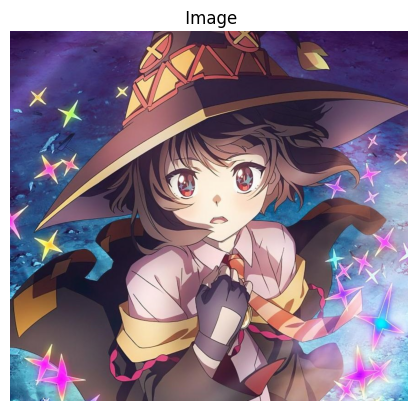

In [3]:
image_url = 'real.jpg'
image = io.imread(image_url)
plt.imshow(image)
plt.title(' Image')
plt.axis('off')
plt.show()

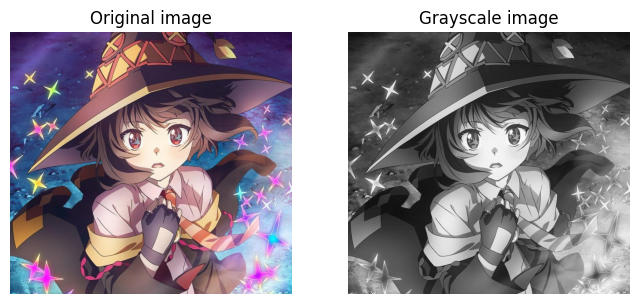

Contrast  236.58550897182968
Dissimilarity  6.156546995800132
Homogeneity  0.4315849152013385
entropy  12.009955150296834


In [18]:


# Load an image

image_gray = img_as_ubyte(rgb2gray(image))  # Convert to grayscale

# Define distances and angles for GLCM
distances = [1, 5, 10]  # Different pixel pair distance offsets
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2, 7*np.pi/4]  # 0, 45, 90, 135 degrees

# Compute GLCM
glcm = graycomatrix(image_gray, distances, angles, 256, symmetric=True, normed=True)

# Compute texture properties
contrast = graycoprops(glcm, 'contrast')[0][0]
dissimilarity = graycoprops(glcm, 'dissimilarity')[0][0]
homogeneity = graycoprops(glcm, 'homogeneity')[0][0]
energy = graycoprops(glcm, 'energy')[0][0]
correlation = graycoprops(glcm, 'correlation')[0][0]
entropy = -np.sum(glcm[:, :, 0, 0] * np.log2(glcm[:, :, 0, 0] + 1e-10))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 16), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Original image')

# Rescale histogram for better display

ax2.axis('off')
ax2.imshow(image_gray, cmap=plt.cm.gray)
ax2.set_title('Grayscale image')
plt.show()

# Print texture features
print("Contrast ", contrast)
print("Dissimilarity ", dissimilarity)
print("Homogeneity ", homogeneity)
print("entropy ",entropy)
# print("Energy:", energy)
# print("Correlation:", correlation)

# # Display the image
# plt.imshow(image_gray, cmap='gray')
# plt.title('Grayscale Image')
# plt.axis('off')
# plt.show()

In [130]:
glcm.shape

(256, 256, 3, 8)

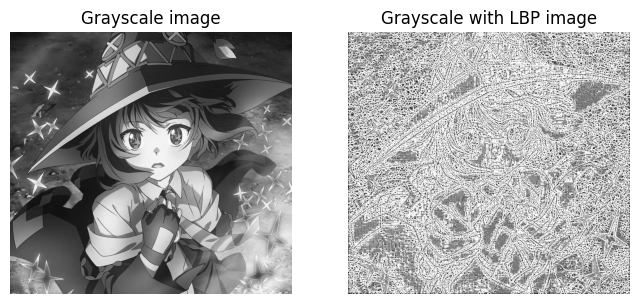

In [13]:

# Parameters for LBP
radius = 3
n_points = 8 * radius

# Calculate LBP
lbp_image = local_binary_pattern(image_gray, n_points, radius, method='uniform')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 16), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image_gray, cmap=plt.cm.gray)
ax1.set_title('Grayscale image')

# Rescale histogram for better display

ax2.axis('off')
ax2.imshow(lbp_image, cmap=plt.cm.gray)
ax2.set_title('Grayscale with LBP image')
plt.show()
# Display the LBP image
# plt.imshow(lbp_image, cmap='gray')
# plt.title('Local Binary Pattern')
# plt.show()

In [16]:
image = io.imread(image_url)
image_gray = img_as_ubyte(rgb2gray(image))

radius = 3
n_points = 8 * radius

lbp_image = local_binary_pattern(image_gray, n_points, radius, method="uniform")

lbglcm = graycomatrix(lbp_image.astype(np.uint8),   distances=[1, 5, 20] , angles=[0], levels=256)

contrast = graycoprops(lbglcm, 'contrast')
dissimilarity = graycoprops(lbglcm, 'dissimilarity')
homogeneity = graycoprops(lbglcm, 'homogeneity')

# energy = graycoprops(lbglcm, 'energy')
# correlation = graycoprops(lbglcm, 'correlation')
# ASM = graycoprops(lbglcm, 'ASM')
entropy = -np.sum(lbglcm[:, :, 0, 0] * np.log2(lbglcm[:, :, 0, 0] + 1e-10))

print("contrast: ", contrast[0][0])
print("dissimilarity: ", dissimilarity[0][0])
print("homogeneity: ", homogeneity[0][0])
print("entropy: ", entropy)

# print("energy: ", energy[0][0])
# print("correlation: ", correlation[0][0])
# print("ASM: ", ASM[0][0])

contrast:  87.232883432063
dissimilarity:  5.308834033764108
homogeneity:  0.4815312738226973
entropy:  -9042233.039077334


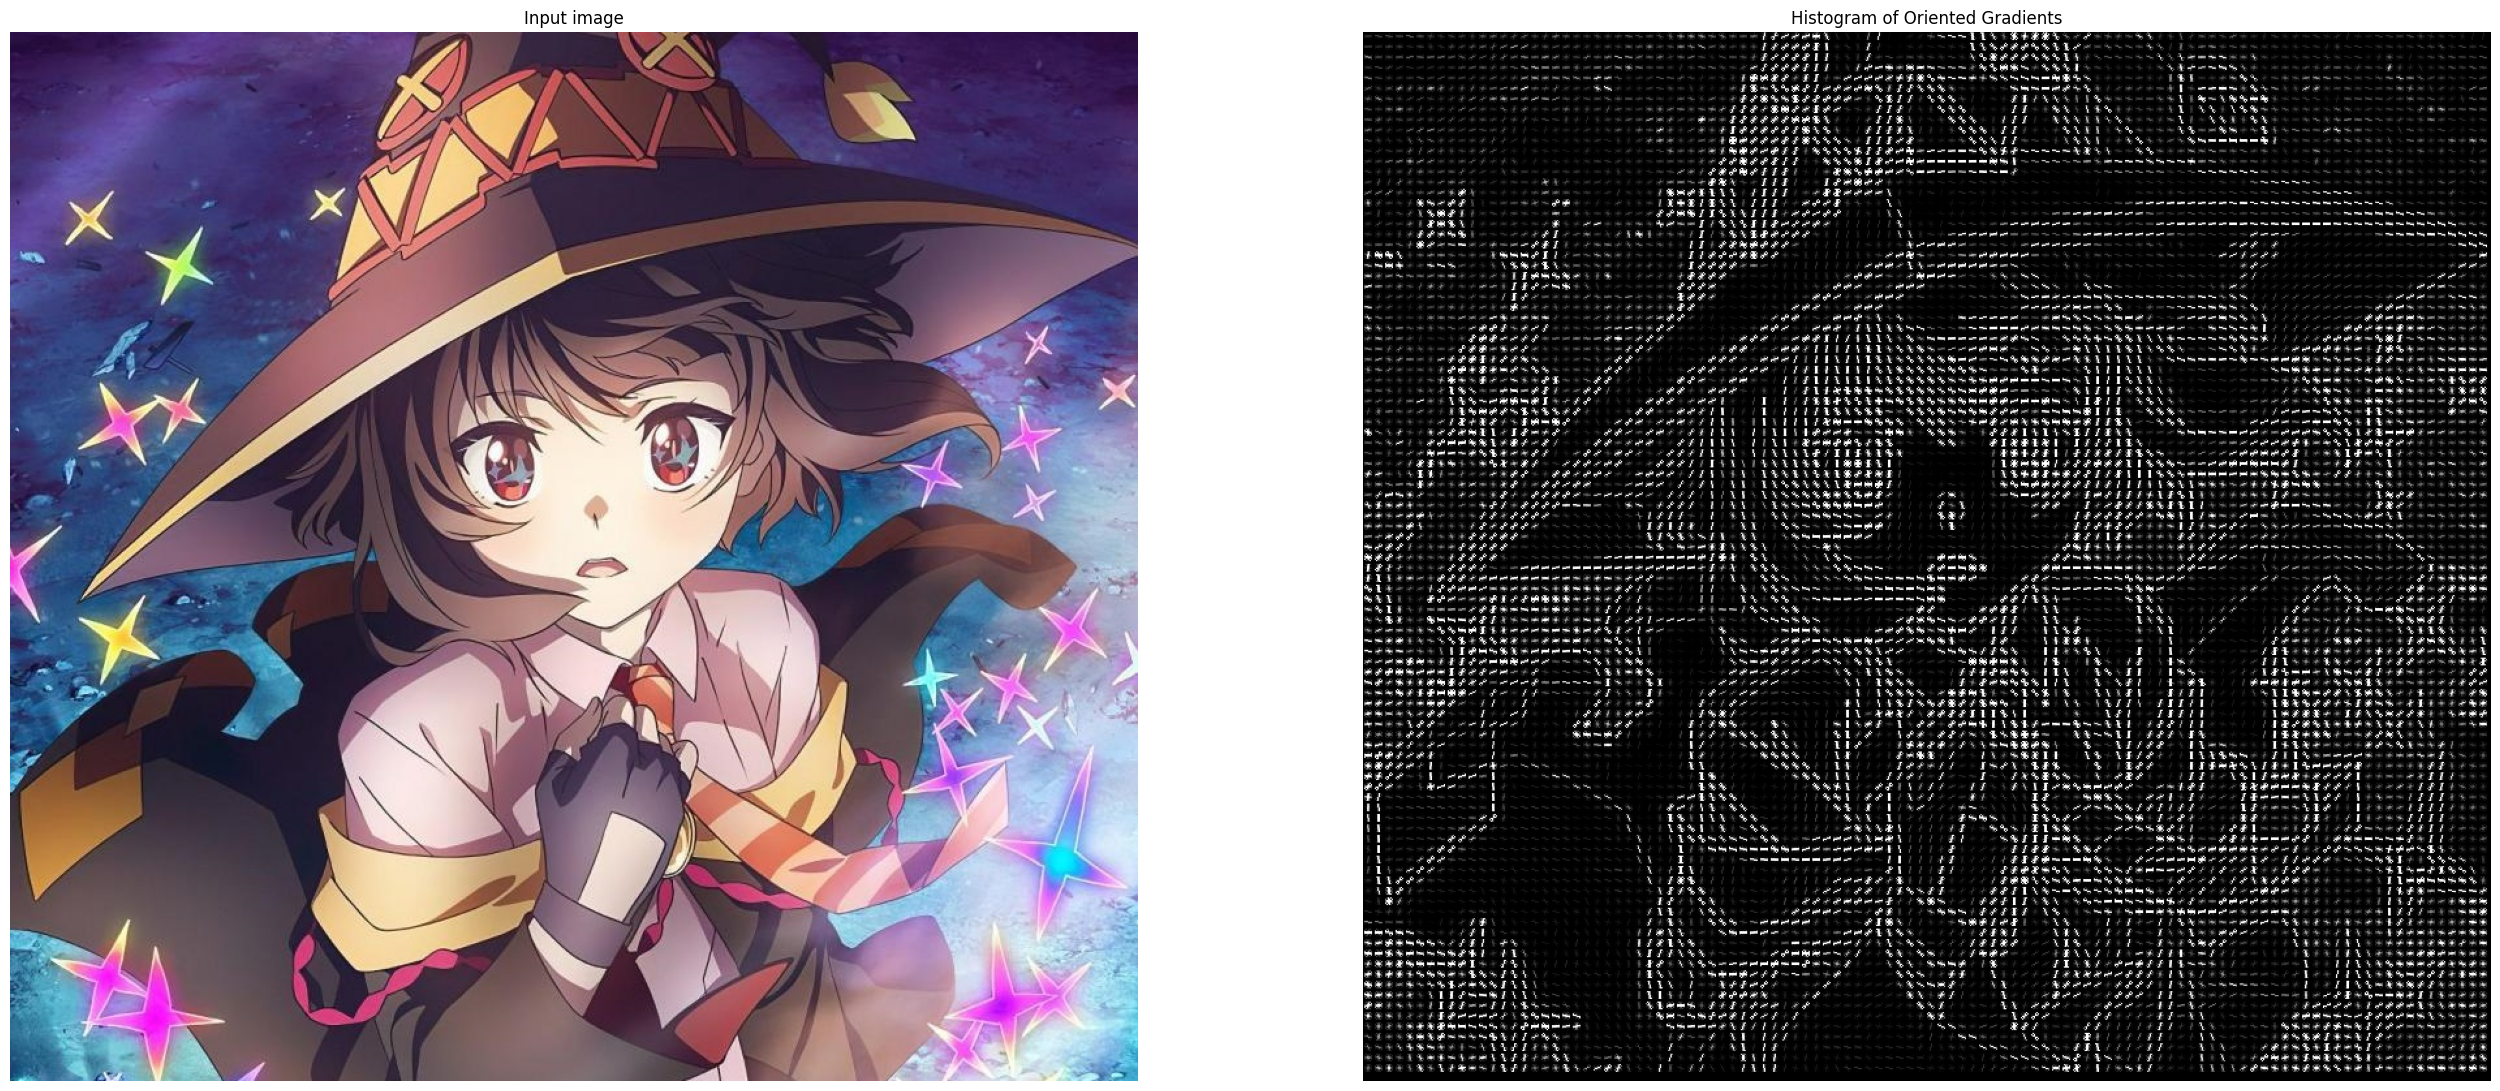

In [9]:
from skimage.feature import hog
from skimage import data, exposure

image = io.imread(image_url)
fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(8, 8),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [151]:
lbglcm = graycomatrix(hog_image_rescaled.astype(np.uint8),   distances=[1, 5, 20] , angles=[0], levels=256)

contrast = graycoprops(lbglcm, 'contrast')
dissimilarity = graycoprops(lbglcm, 'dissimilarity')
homogeneity = graycoprops(lbglcm, 'homogeneity')
energy = graycoprops(lbglcm, 'energy')
correlation = graycoprops(lbglcm, 'correlation')
ASM = graycoprops(lbglcm, 'ASM')

print("contrast: ", contrast[0][0])
print("dissimilarity: ", dissimilarity[0][0])
print("homogeneity: ", homogeneity[0][0])
print("energy: ", energy[0][0])
print("correlation: ", correlation[0][0])
print("ASM: ", ASM[0][0])

contrast:  0.20161290322580644
dissimilarity:  0.20161290322580644
homogeneity:  0.8991935483870969
energy:  0.6797255770100338
correlation:  0.46522911051212945
ASM:  0.4620268600416234


In [198]:
import numpy as np

def calculate_glrlm(image_url, levels=256):
    # Initialize the GLRLM matrix
    image = io.imread(image_url)
    
    image_gray = img_as_ubyte(rgb2gray(image))
    glrlm = np.zeros((levels, image.shape[1]), dtype=int)
    
    # Calculate GLRLM
    for i in range(image.shape[0]):
        run_length = 0
        previous_value = image[i, 0]
        for j in range(image.shape[1]):
            if image[i, j] == previous_value:
                run_length += 1
            else:
                glrlm[previous_value, run_length-1] += 1
                run_length = 1
                previous_value = image[i, j]
        glrlm[previous_value, run_length-1] += 1  # For the last run in the row
        
    return glrlm

def short_runs_emphasis(glrlm):
    # Calculate Short Runs Emphasis
    j = np.arange(1, glrlm.shape[1] + 1)
    return np.sum(glrlm / j**2) / np.sum(glrlm)

# Example usage
image = (image_gray * 255).astype(np.uint8)  # Assuming 'image' is already loaded and normalized
glrlm = calculate_glrlm(image)
sre = short_runs_emphasis(glrlm)
print("Short Runs Emphasis:", sre)

OSError: Cannot understand given URI: array([[224, 224, 225, ..., 236, 235, 234],
       [228, ....